In [1]:
import os
from astropy.io import fits
from astropy import wcs
import numpy as np
from scipy import ndimage

def random_flux_powerlaw(alpha, Fmin, Fmax):
    found = False
    while not found:
        x = np.random.uniform(Fmin,Fmax)
        y = np.random.uniform(0, Fmin**(alpha)) 
        if y < x**(alpha):
            frand = x
            found = True
    return frand

# Generate model image
def make_model_map(model_map_name, model_cat, residmap, sourcemap, \
                   Fmin, Fmax, alpha, Nsrc, Fracpoint=1., verbose=3):
    
    print("making ", model_map_name)

    if isinstance(Nsrc, np.float):
        Nsrc = int(Nsrc)

    os.system('cp %s %s.old' %(residmap,residmap))

    ## get some info from the source image ##
    sourcehead = fits.getheader(sourcemap)
    beam_maj = sourcehead.get('BMAJ')
    beam_min = sourcehead.get('BMIN')
    beam_pa = sourcehead.get('BPA')
    # or it is not there, check the history
    if beam_maj is None:
        hist = sourcehead.get_history()
        for i in range(len(hist)):
            t = hist[i]
            if 'BMAJ=' in t:
                tt = t.split()
                beam_maj = float(tt[tt.index('BMAJ=')+1])
            if 'BMIN=' in t:
                tt = t.split()
                beam_min = float(tt[tt.index('BMIN=')+1])
            if 'BPA=' in t:
                tt = t.split()
                beam_pa = float(tt[tt.index('BPA=')+1])
    mapwcs = wcs.WCS(sourcehead)
    
    ps = abs(sourcehead.get('CDELT1'))*3600.  #arcsec per pixel
    fwhm_beam_pix = beam_maj*3600./ps    #pixels
    fwhm_beam_maj_pix = beam_maj*3600./ps    #pixels
    fwhm_beam_min_pix = beam_min*3600./ps    #pixels
    fwhm_beam = beam_maj*3600.    #arcsec
    fwhm_beam_maj = beam_maj*3600.    #arcsec
    fwhm_beam_min = beam_min*3600.    #arcsec
    
    print(ps,beam_maj)
    
    ## get the residual data ##
    residall = fits.getdata(residmap)#.transpose()
    S = residall.shape
    Nax = len(S)
    if Nax > 2:
        residall = residall[0,0,:,:]
    
    resid=residall
    
    S = resid.shape
    Nax = len(S)
    model = np.zeros(resid.shape)
    
    modelfits = model_map_name
    
    if verbose > 2: print('shape:', model.shape)
    
    fwhm_f = 2.*np.sqrt(2.*np.log(2.))
    sig_beam = fwhm_beam_pix/fwhm_f    ##pixels/
    sig_beam_maj = fwhm_beam_maj_pix/fwhm_f    ##pixels/
    sig_beam_min = fwhm_beam_min_pix/fwhm_f    ##pixels/
    
    Speak = np.zeros(Nsrc)
    Flux = np.zeros(Nsrc)
    bmaj = np.zeros(Nsrc)
    bmin = np.zeros(Nsrc)
    bpa = np.zeros(Nsrc)
    ra = np.zeros(Nsrc)
    dec = np.zeros(Nsrc)
    pnt = np.zeros(Nsrc)
    
    n_ext2 = 0
    if verbose > 1: print('beam = %.3f pix' %(fwhm_beam_pix))
    if verbose > 1: print('beam maj = %.3f pix' %(fwhm_beam_maj_pix))
    if verbose > 1: print('beam min = %.3f pix' %(fwhm_beam_min_pix))
    if verbose > 1: print('beam = %.3f arcsec' %(fwhm_beam))
    
    if verbose > 1: print('sig_beam', sig_beam)
    
    C = 6
    Psize = np.ceil(max(C*sig_beam, C*sig_beam))
    x0 = Psize
    y0 = Psize  
    xg = np.arange(0, 2*Psize, 1, float)
    yg = xg[:,np.newaxis]
    rota = np.pi/180. * (beam_pa-90)
    x0p = x0 * np.cos(rota) - y0 * np.sin(rota)
    y0p = x0 * np.sin(rota) + y0 * np.cos(rota)
    xp = xg * np.cos(rota) - yg * np.sin(rota)
    yp = xg * np.sin(rota) + yg * np.cos(rota)
    gaus_point = np.exp( -( (((x0p-xp)**2.)/(2.*sig_beam_maj**2.)) + (((y0p-yp)**2.)/(2.*sig_beam_min**2.)) ) )
    
    if verbose > 1: print('gaussian point shape: ',gaus_point.shape)
    
    #valid_coords    
    nx,ny=resid.shape
    # set edges to nan
    resid[0,:] *= np.nan
    resid[-1,:] *= np.nan
    resid[:,0] *= np.nan
    resid[:,-1] *= np.nan
    badmask = np.isnan(resid)
    
    # grow mask in all directions by 50 pixels
    badmask = ndimage.morphology.binary_dilation(badmask, iterations=int(1.5*Psize))  
    x_good,y_good = np.where(~badmask)
    N_good = len(x_good)

    xlist = 999.*np.ones(Nsrc)
    ylist = 999.*np.ones(Nsrc)
    
    for i in range(Nsrc):
        if i%100 == 0:
            print('%i of %i' %(i,Nsrc))
        # decide if it is a point
        randpoint = np.random.uniform(0.,1.)
        if randpoint < Fracpoint:
            point = True
        else:
            point = False
        # repeat until we have a valid source (invalids occur on NaNs and near edges)
        result = False
        indi = 0
        nx, ny = model.shape
        while not result:
            result = True
            indi += 1
            N_good = len(x_good)
            i_c = np.random.randint(0,N_good)
            x = x_good[i_c]
            y = y_good[i_c]
            if np.min(np.sqrt((x-xlist)**2+(y-ylist)**2)) < 2.*fwhm_beam_pix:
                result = False
            if np.isnan(np.sum(resid[int(x-fwhm_beam_pix):int(x+fwhm_beam_pix),\
                                     int(y-fwhm_beam_pix):int(y+fwhm_beam_pix)])):
            # source is in a bad place on the map - somewhere a nan in a box fwhm_beam_pix  X fwhm_beam_pix 
                result = False
        # draw flux
        flux = random_flux_powerlaw(alpha=alpha-1, Fmin=Fmin, Fmax=Fmax)
        pixcrd = np.array([[y,x,0,0]], np.float_)
        world = mapwcs.wcs_pix2world(pixcrd, 0)
        if point:
            sx = sig_beam_maj
            sy = sig_beam_min
            ba = 0.
            pa = beam_pa
            peak = flux #/(np.pi*sx*sy)   # Jy/beam in pix
            x1 = int(np.floor(x) - Psize)
            x2 = int(np.ceil(x) + Psize)
            y1 = int(np.floor(y) - Psize)
            y2 = int(np.ceil(y) + Psize)
            try:
                model[x1:x2,y1:y2] += peak*gaus_point
                pnt[i] = 1
            except:
                print("ERROR!!")
                print(x1,x2,y1,y2)
        else:
            # more sources slightly resolved out to 2x beam
            sx = np.random.triangular(sig_beam,sig_beam, 4.*sig_beam)
            ba = np.random.triangular(0.4,1.,1.)  #rounder sources more common and no extreme
            sy = sx*ba
            if sy < sig_beam_min:
                sy = sig_beam_min
            pa = np.random.uniform(0.,180.)
            peak = flux /(sx*sy/(sig_beam_maj*sig_beam_min))   # Jy/beam in pix
            C = 6
            if sx/sy < 0.2:
                C = 8
            size = np.ceil(max(C*sx, C*sy))
            x1 = np.floor(x) - size
            x2 = np.ceil(x) + size
            y1 = np.floor(y) - size
            y2 = np.ceil(y) + size
            xg = np.arange(0, 2*size, 1, float)
            yg = xg[:,np.newaxis]
            rota = np.pi/180. * (pa-90.)
            x0 = size
            y0 = size
            x0p = x0 * np.cos(rota) - y0 * np.sin(rota)
            y0p = x0 * np.sin(rota) + y0 * np.cos(rota)
            xp = xg * np.cos(rota) - yg * np.sin(rota)
            yp = xg * np.sin(rota) + yg * np.cos(rota)
            g = np.exp( -( (((x0p-xp)**2.)/(2.*sx**2.)) + (((y0p-yp)**2.)/(2.*sy**2.)) ) )
            try:
                model[x1:x2,y1:y2] += peak*g
            except:
                print("ERROR!!")
                print(size, x1,x2,y1,y2, model.shape, model[x1:x2,y1:y2].shape, g.shape, Speak)
            n_ext2 += 1
            pnt[i] = 0
        xlist[i] = x
        ylist[i] = y
        Speak[i] = peak
        Flux[i] = flux #/(np.pi*fwhm_beam**2. ))
        bmaj[i] = sx*fwhm_f*ps  #in arcsec
        bmin[i] = sy*fwhm_f*ps  #in arcsec
        bpa[i] = pa
        ra[i] = world[0][0] #-ps/3600.
        dec[i] = world[0][1] #-ps/3600.
    # end generate sources #
    
    print('%i extended sources (%.3f per cent) ' %(n_ext2, 100.*n_ext2/Nsrc))
    
    # add noise to map
    print('Adding noise')
    modeln = model+resid
    #modeln = model

    # write to fits
    modelfits = model_map_name
    if os.path.isfile(modelfits):
        os.system( 'rm '+modelfits )
    fits.writeto(modelfits, modeln[np.newaxis,np.newaxis,:,:], sourcehead, output_verify='fix')
    
    # write input catalogue
    catfile = open(model_cat+'.tempascii','w')
    catfile.write('# Source_id ra dec Total_flux Peak_flux Bmaj Bmin Bpa\n')
    for i in range(len(Speak)):
        catfile.write('%i %.6f %.6f %f %f %f %f %f\n' %(i,ra[i],dec[i],Flux[i],Speak[i],bmaj[i],bmin[i],bpa[i]))
    catfile.close()
    
    # Region file format: DS9 version 4.0
    catfile = open(model_cat+'.reg','w')
    head = '''global color=yellow font="helvetica 10 normal" select=1 highlite=1 edit=1 move=1 \
    delete=1 include=1 fixed=0 source fk5'''
    catfile.write(head)
    for i in range(len(Speak)):
        if pnt[i] == 1:
            catfile.write('ellipse(%f,%f,%f",%f",%f)# text={%i} color={yellow}\n'\
                          %(ra[i],dec[i],bmaj[i],bmin[i],bpa[i],i))
        else:
            catfile.write('ellipse(%f,%f,%f",%f",%f)# text={%i} color={blue}\n' \
                          %(ra[i],dec[i],bmaj[i],bmin[i],bpa[i]-90.,i))
    catfile.close()
    # save as fits table
    #os.system("stilts tcopy in=%s out=%s ifmt=ascii ofmt=fits" %(model_cat+'.tempascii',model_cat))
    #os.system("rm -rf %s" %(model_cat+'.tempascii'))
    return Speak, Flux

MC_iters = 10 
for i in range(MC_iters):
    ### 61 MHz ###
    #Speak, Flux = make_model_map('Completeness_correction_fdr/A12_MC_model_map_fdr'+str(i)+'.fits',\
    #                             'Completeness_correction_fdr/A12_MC_model_catalog_fdr'+str(i), \
    #                             'images_cat_61MHz/A12_ZEA_18Feb19_gresid_fdr.fits', \
    #              'PD_code/A12_18Feb19_MASKED_UVcut-MFS-ZEA-image-pb.fits', 0.5, 90., -0.6, 4000.)
    ###
    ### 41 MHz ###
    Speak, Flux = make_model_map('Completeness_correction_fdr_41MHz/A12_MC_model_map_fdr'+str(i)+'.fits',\
                                 'Completeness_correction_fdr_41MHz/A12_MC_model_catalog_fdr'+str(i), \
                                 'images_cat_41MHz/A12_PBcorr_41MHz_MASKED_ZEA_UVcut-MFS-gresid.fits', \
                                 'images_cat_41MHz/A12_PBcorr_41MHz_MASKED_ZEA_UVcut-MFS-image-pb.fits', \
                                 0.5, 90., -0.6, 4000.)
    ###
#print(Speak, Flux)

making  Completeness_correction_fdr_41MHz/A12_MC_model_map_fdr0.fits
360.0 0.398947830186483
shape: (714, 796)
beam = 3.989 pix
beam maj = 3.989 pix
beam min = 2.722 pix
beam = 1436.212 arcsec
sig_beam 1.694175446774913
gaussian point shape:  (22, 22)
0 of 4000
100 of 4000
200 of 4000
300 of 4000
400 of 4000


500 of 4000
600 of 4000
700 of 4000
800 of 4000
900 of 4000
1000 of 4000
1100 of 4000
1200 of 4000
1300 of 4000
1400 of 4000
1500 of 4000
1600 of 4000
1700 of 4000
1800 of 4000
1900 of 4000
2000 of 4000
2100 of 4000
2200 of 4000
2300 of 4000
2400 of 4000
2500 of 4000
2600 of 4000
2700 of 4000
2800 of 4000
2900 of 4000
3000 of 4000
3100 of 4000
3200 of 4000
3300 of 4000
3400 of 4000
3500 of 4000
3600 of 4000
3700 of 4000
3800 of 4000
3900 of 4000
0 extended sources (0.000 per cent) 
Adding noise
making  Completeness_correction_fdr_41MHz/A12_MC_model_map_fdr1.fits
360.0 0.398947830186483
shape: (714, 796)
beam = 3.989 pix
beam maj = 3.989 pix
beam min = 2.722 pix
beam = 1436.212 arcsec
sig_beam 1.694175446774913
gaussian point shape:  (22, 22)
0 of 4000
100 of 4000


 [astropy.io.fits.verify]


200 of 4000
300 of 4000
400 of 4000
500 of 4000
600 of 4000
700 of 4000
800 of 4000
900 of 4000
1000 of 4000
1100 of 4000
1200 of 4000
1300 of 4000
1400 of 4000
1500 of 4000
1600 of 4000
1700 of 4000
1800 of 4000
1900 of 4000
2000 of 4000
2100 of 4000
2200 of 4000
2300 of 4000
2400 of 4000
2500 of 4000
2600 of 4000
2700 of 4000
2800 of 4000
2900 of 4000
3000 of 4000
3100 of 4000
3200 of 4000
3300 of 4000
3400 of 4000
3500 of 4000
3600 of 4000
3700 of 4000
3800 of 4000
3900 of 4000
0 extended sources (0.000 per cent) 
Adding noise
making  Completeness_correction_fdr_41MHz/A12_MC_model_map_fdr2.fits
360.0 0.398947830186483
shape: (714, 796)
beam = 3.989 pix
beam maj = 3.989 pix
beam min = 2.722 pix
beam = 1436.212 arcsec
sig_beam 1.694175446774913
gaussian point shape:  (22, 22)
0 of 4000
100 of 4000
200 of 4000
300 of 4000
400 of 4000
500 of 4000
600 of 4000
700 of 4000
800 of 4000
900 of 4000
1000 of 4000
1100 of 4000
1200 of 4000
1300 of 4000
1400 of 4000
1500 of 4000
1600 of 4000
170

/home/shulevski/miniconda2/envs/tess/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater


fraction_total_MC_n:  [[ 0.  0. 12. 44. 70. 80. 66. 48. 63. 48. 11. nan]
 [ 0.  0. 13. 53. 84. 70. 63. 46. 52. 28. 16. nan]
 [ 0.  2. 14. 39. 69. 58. 55. 65. 43. 48. 18. nan]
 [nan  0. 11. 45. 74. 75. 69. 48. 53. 30. 17. nan]
 [nan nan  4. 42. 81. 81. 61. 59. 53. 40. 15. nan]
 [ 0.  1. 19. 53. 76. 78. 65. 60. 43. 46. 13. nan]
 [nan nan  8. 33. 77. 85. 61. 65. 55. 50. 25. nan]
 [nan  1.  5. 45. 79. 84. 75. 48. 49. 46. 12. nan]
 [ 0.  1. 10. 46. 74. 82. 88. 63. 58. 43. 11. nan]
 [nan  1.  8. 43. 77. 72. 64. 65. 55. 49. 14. nan]]
Bins:  [  3.63402114   4.9443834    6.72723859   9.1529591   12.45335054
  16.9438034   23.05343232  31.36608288  42.67612481  58.06436322
  79.00132195 107.48776917 146.2459138 ]
Binc:  [  4.28920227   5.835811     7.94009884  10.80315482  14.69857697
  19.99861786  27.2097576   37.02110384  50.37024401  68.53284258
  93.24454556 126.86684149]
Image RMS:  1.909891975017942
Areas:  [0.51708922 0.64769777 0.77454379 0.88231891 0.95305187 0.98564783
 0.99559204 0.9

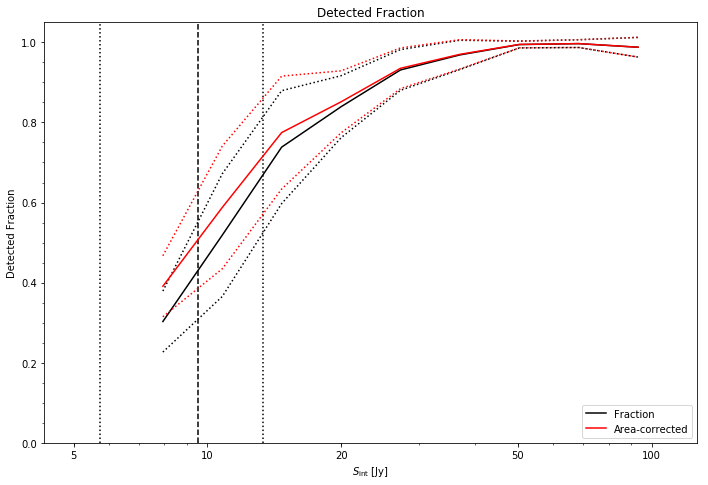

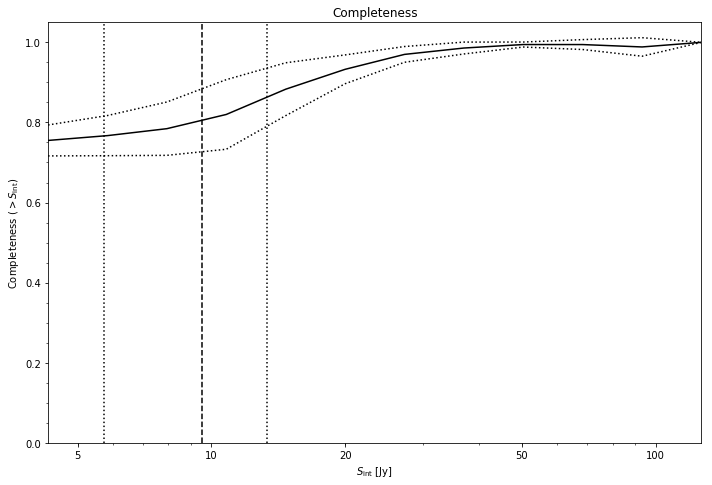

In [19]:
%matplotlib inline
# Completeness calculation

from  astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
from matplotlib.ticker import MultipleLocator, LogFormatter, LogLocator, FuncFormatter

def get_differential_area(RMSMap, frange, detect_thresh=5.0):
    rms = fits.getdata(RMSMap)
    rmsdat = np.ma.masked_where(np.isnan(rms), rms).compressed()
    rmshead = fits.getheader(RMSMap)
    # calculate the fraction of area available for sources to be found
    area_i = np.ones(len(frange))
    pixels = np.sum(rmsdat < frange[-1]/detect_thresh)
    ps = rmshead.get('CDELT2') #pixel scale : pix = ps degrees
    degtosterad = (np.pi/180.)**2.
    Area_tot =  pixels*ps*ps * degtosterad
    for i in range( len(frange)-2 ): 
        # area of map in which source could be found (S > 5 sigma, sigma < S/5)
        rmslim = frange[i+2]/detect_thresh
        pixels = np.sum(rmsdat < rmslim)
        if pixels == 0:
            area_i[i] = np.nan
            continue
        Area = pixels*ps*ps
        Area_st = Area * degtosterad
        #area_i[i] = Area_st/Area_tot
        area_i[i] = Area_st
    return area_i

#bins = np.array([1.00551191, 1.48492603, 2.19291816, 3.2384711, 4.78252917, \
#                 7.0627727, 10.4302047, 15.40318153, 22.74720469, 33.59275617, \
#                 49.60931607, 73.26234941, 108.19282077]) # 61 MHz

bins = np.array([3.63402114, 4.9443834, 6.72723859, 9.1529591, 12.45335054, 16.9438034, \
                 23.05343232, 31.36608288, 42.67612481, 58.06436322, 79.00132195, \
                 107.48776917, 146.2459138]) # 41 MHz

fraction_total_MC = []
fraction_total_MC_n = []
fraction_total_MC_d = []

for catalog in glob.glob('Completeness_correction_fdr_41MHz/A12_MC_model_catalog*_match.fits'):
    #freq = 61.
    freq = 41.7
    
    cat = Table.read(catalog, hdu=1)
    pcat = cat.to_pandas()

    inpeak = np.array(pcat['Peak_flux_1'])
    outpeak = np.array(pcat['Peak_flux_2'])
    influx = np.array(pcat['Total_flux_1'])
    outflux = np.array(pcat['Total_flux_2'])
    rms = np.array(pcat['Isl_rms'])
    nsrc = len(pcat.index)

    mask_high = outpeak/inpeak > 1.3
    #  Test ##
    #mask_high = outpeak/inpeak > 1.2
    ###
    mask_low = outpeak/inpeak < 0.77
    mask_bad_m = np.ma.mask_or(mask_low, mask_high)
    mask_bad = np.where(mask_bad_m)[0] 
    outflux[mask_bad] = np.nan*np.ones(len(mask_bad))
    outpeak[mask_bad] = np.nan*np.ones(len(mask_bad))

    #print(outpeak/inpeak)

    total_dfrac = np.ones(len(bins)-1)*np.nan
    total_dfrac_n = np.ones(len(bins)-1)*np.nan
    total_dfrac_d = np.ones(len(bins)-1)*np.nan

    for k in range(len(bins)-1):
        mask = 1-((influx > bins[k]) * (influx < bins[k+1]))
        influx_mask = np.ma.masked_where(mask, influx).compressed()
        nsrc_mask = len(influx_mask)
        outflux_mask = np.ma.masked_where(mask, outflux).compressed()
        detections = np.sum(outflux_mask > 0.)  #-1 are non-detections
        if nsrc_mask == 0.:
            total_dfrac[k] = 0.
        else:
            total_dfrac[k] = float(detections)/nsrc_mask
            total_dfrac_n[k] = float(detections)
            total_dfrac_d[k] = nsrc_mask

    #print('FLUX        DF Tot Frac')
    #for k in range(len(total_dfrac)):
    #    print('%10.3f %3.0f %3.0f %5.3f' %( bins[k], total_dfrac_n[k], total_dfrac_d[k], \
    #                                        total_dfrac_n[k]/total_dfrac_d[k] ))
    fraction_total_MC.append(total_dfrac)
    fraction_total_MC_n.append(total_dfrac_n)
    fraction_total_MC_d.append(total_dfrac_d)
    
binc = (bins[:-1] + bins[1:])/2.

fraction_total_MC_n = np.array(fraction_total_MC_n)
fraction_total_MC_d = np.array(fraction_total_MC_d)
fraction_total_MC = fraction_total_MC_n/fraction_total_MC_d

print('fraction_total_MC_n: ', fraction_total_MC_n)
print('Bins: ', bins)
print('Binc: ', binc)

fraction_total_MC_mean = np.average(fraction_total_MC_n/fraction_total_MC_d, axis=0)
fraction_total_MC_sig = np.std(fraction_total_MC_n/fraction_total_MC_d, axis=0)

# Getting areas
#rmsdat = fits.getdata('Completeness_correction/A12_MC_model_map1_gresid.fits')[0]
rmsdat = fits.getdata('Completeness_correction_fdr_41MHz/A12_MC_gresid_fdr6.fits')[0]
rmsdat = rmsdat[np.isfinite(rmsdat)]
rmsdat = rmsdat[rmsdat>0]
rmsdat = rmsdat.flatten()

print('Image RMS: ', np.std(rmsdat))

Area_rms_int = np.nan*np.ones(len(binc))
pixel_tot = 1.0*np.sum(np.isfinite(rmsdat))
for i in range(len(binc)):
    fp = bins[i+1]
    rmslim = fp/3.
    pixel = np.sum(rmsdat < rmslim)
    Area_rms_int[i] = pixel/pixel_tot
    
#Area_rms_int = get_differential_area('Completeness_correction/A12_MC_model_map1_gresid.fits', \
#                                     binc, detect_thresh=5.0)

# 1/Area
#Area_rms_int = np.array([369.997898, 4.20776855, 0.96534318, 0.77820618, 0.76627812, 0.76282908, \
#                         0.76275287, 0.76275287, 0.76275287, 0.76275287, 0.76275287, 0.76275287])
#Area_rms_int = 1./Area_rms_int

fig1=plt.figure(figsize=(11, 8))
ax1=fig1.add_subplot(111)
ax1.minorticks_on()
ax1.semilogx(binc,fraction_total_MC_mean,'k', label='Fraction')
ax1.semilogx(binc,fraction_total_MC_mean+fraction_total_MC_sig,'k:')
ax1.semilogx(binc,fraction_total_MC_mean-fraction_total_MC_sig,'k:')
ax1.semilogx(binc,fraction_total_MC_mean/Area_rms_int,'r', label='Area-corrected')
ax1.semilogx(binc,fraction_total_MC_mean/Area_rms_int+fraction_total_MC_sig,'r:')
ax1.semilogx(binc,fraction_total_MC_mean/Area_rms_int-fraction_total_MC_sig,'r:')
ax1.vlines(5.*np.std(rmsdat),0,1.05,linestyle='dashed')
ax1.vlines(3.*np.std(rmsdat),0,1.05,linestyle='dotted')
ax1.vlines(7.*np.std(rmsdat),0,1.05,linestyle='dotted')
ax1.set_ylabel('Detected Fraction')
ax1.set_xlabel('$S_{\mathrm{int}}$ [Jy] ')
ax1.set_ylim(0,1.05)
ax1.set_xlim(binc.min(), binc.max())
#ax1.set_xlim(5., 100.)
ax1.minorticks_on()
plt.subplots_adjust(bottom=0.15,right=0.95)
ax1.set_title('Detected Fraction')
ax1.legend(loc='lower right')
ax1.xaxis.set_major_locator(LogLocator(subs=[1,2,5]))
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x) if x < 1 else ('%.0f')%(x)))

np.save('Completeness_correction_fdr_41MHz/A12_Detection_fraction_int_i_test_41MHz.npy', [binc, fraction_total_MC_mean,\
                                            fraction_total_MC_sig,fraction_total_MC_mean/Area_rms_int])

print('Areas: ', Area_rms_int)
print('Fraction:', fraction_total_MC_mean)

# Completeness is sum of sources detected above flux S over 
# sum of sources which we could have detected (ie input distribution scaled down by area fraction)
completeness_diff_n = (fraction_total_MC_n) #/(area_i)
completeness_diff_d = (fraction_total_MC_d)  #*(area_i)

nanind = np.where(np.isnan(completeness_diff_d) & np.isnan(completeness_diff_n))
dennanind = np.where(np.isnan(completeness_diff_d) & np.isfinite(completeness_diff_n))
numnanind = np.where(np.isnan(completeness_diff_n) & np.isfinite(completeness_diff_n))

completeness_diff_d[nanind] = 1
completeness_diff_n[nanind] = 1

completeness_int = np.zeros(completeness_diff_n.shape)

completeness_int_area = np.zeros(completeness_diff_n.shape)
for i in range(len(bins)-1):
    completeness_int[:,i] = np.sum(completeness_diff_n[:,i:],axis=1)/np.sum(completeness_diff_d[:,i:],axis=1)
Comp = np.nanmean(completeness_int, axis=0)
Comp_sd = np.nanstd(completeness_int, axis=0)

plt.savefig("/home/shulevski/Documents/Research/Projects/A12_source_counts/" + \
"Completeness_correction_fdr_41MHz/A12_det_frac_41MHz.pdf")

fig2=plt.figure(figsize=(11, 8))
ax2=fig2.add_subplot(111)

try:
    ax2.semilogx(binc,Comp,'k')
except:
    print(binc)
    print(Comp)

ax2.semilogx(binc,Comp+Comp_sd,'k:')
ax2.semilogx(binc,Comp-Comp_sd,'k:')
ax2.vlines(5.*np.std(rmsdat),0,1.05,linestyle='dashed')
ax2.vlines(3.*np.std(rmsdat),0,1.05,linestyle='dotted')
ax2.vlines(7.*np.std(rmsdat),0,1.05,linestyle='dotted')
ax2.set_ylabel('Completeness ($>S_{\mathrm{int}}$)')
ax2.set_xlabel('$S_{\mathrm{int}}$ [Jy] ')
ax2.set_ylim(0,1.05)
ax2.set_xlim(binc.min(), binc.max())
#ax1.set_xlim(5., 100.)
ax2.minorticks_on()
plt.subplots_adjust(bottom=0.15,right=0.95)
ax2.set_title('Completeness')
ax2.xaxis.set_major_locator(LogLocator(subs=[1,2,5]))
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x) if x < 1 else ('%.0f')%(x)))
for i in range(len(Comp)):
    if np.isnan(Comp[i]): Comp[i] = 0.
x = np.linspace(binc.min(),binc.max(),len(binc)*10)
y = np.interp(x, binc, Comp)

#np.save('A12_Completeness_int_i.npy', [binc, Comp])
plt.savefig("/home/shulevski/Documents/Research/Projects/A12_source_counts/" + \
            "Completeness_correction_fdr_41MHz/A12_compl_41MHz.pdf")

print('#Completeness#')
print('90%% complete above: %.2f Jy' %(x[np.sum(y<0.9) -1]))
print('95%% complete above: %.2f Jy' %(x[np.sum(y<0.95) -1]))
print('97.5%% complete above: %.2f Jy' %(x[np.sum(y<0.975) -1]))
print('100%% complete above: %.2f Jy' %(x[np.sum(y<1.) -1]))

In [6]:
ls PD_code/

A12_18Feb19_MASKED-MFS-ZEA-image-pb.fits             PofD_code_3may2019.tgz
A12_18Feb19_MASKED_UVcut-MFS-ZEA-image-pb.fits       __pycache__/
A12_18Feb19_MASKED_UVcut-MFS-ZEA-image-pb.fits.safe  pypofd.py*
A12_results/                                         select_region.sh*
A12_results_UVcut/                                   test/
pofd_analysis.py*


In [4]:
pwd

'/home/shulevski/Documents/Research/Projects/A12_source_counts'